In [1]:
import os
os.chdir("../")

In [26]:
import wandb
import torch
import random
import time
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import optim
from tqdm.notebook import tqdm
from models.mobilenetv2 import mobilenetv2
from data.affwild2_dataset import AffWild2ExprDataset
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import StepLR
from typing import Any
from torchvision import datasets
from collections import namedtuple
from torchvision.models import resnet18

import warnings
warnings.filterwarnings("ignore")

In [3]:
%load_ext autoreload
%autoreload 2

# Utility Functions

In [4]:
def random_seed(seed):
    """Set seed"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

def store_params(content, name):
    f = open(f'params/{name}.pkl','wb')
    pickle.dump(content, f)
    f.close()

def load_params(name):
    fl = open(f'params/{name}.pkl', "rb")
    loaded = pickle.load(fl)
    return loaded

def store_model(model, name):
    torch.save(model.state_dict(), f'./trained_models/{name}.pth')
                                

# Data Preparation

In [5]:
project_name = 'moody_much'
cores = 8
random_seed(8)
batch_size = 256
num_classes = 2
skip = 0
input_dim = 112

mean = [0.4722, 0.3625, 0.3350]
std = [0.2181, 0.1921, 0.1855]

In [6]:
identity_transform = transforms.Compose([
    transforms.ToTensor()
])

mean = 0.
std = 0.
train_dataset = AffWild2ExprDataset(train=True, skip=skip, remove_mismatch=True, 
                                    compress=True, 
                                    transform=identity_transform, binary=True)

loader = DataLoader(train_dataset, batch_size=batch_size)
for images, _ in tqdm(loader):
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(loader.dataset)
std /= len(loader.dataset)

mean, std

KeyboardInterrupt: 

In [18]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(0.2),
    transforms.RandomAffine(30),
    #transforms.RandomResizedCrop((112,112)),
    #transforms.GaussianBlur((65, 65), sigma=(0.1, 2.0)),
    transforms.Normalize(mean=mean, std=std),
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

train_dataset = AffWild2ExprDataset(train=True, skip=skip, remove_mismatch=True,
                                    compress=True, transform=transform_train, binary=True)
valid_dataset = AffWild2ExprDataset(train=False, skip=skip, remove_mismatch=True,
                                    compress=True, transform=transform_valid, binary=True)

In [19]:
len(train_dataset), len(valid_dataset)

(49218, 15266)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1

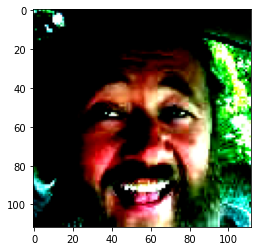

In [8]:
s, l = train_dataset[100]
s.shape

_ = plt.imshow(s.numpy().transpose(1, 2, 0))
l

In [20]:
total_valid_num = len(valid_dataset)
total_train_num = len(train_dataset)
valid_num = int(0.5 * total_valid_num)

valid_mask = list(range(valid_num))
test_mask = list(range(valid_num, total_valid_num))

valid_loader = DataLoader(Subset(valid_dataset, valid_mask), batch_size=batch_size, 
                          shuffle=True, num_workers=cores)
test_loader = DataLoader(Subset(valid_dataset, test_mask), batch_size=batch_size, 
                         shuffle=True, num_workers=cores)

small_train_mask = random.sample(range(total_train_num), 500)
medium_train_mask = random.sample(range(total_train_num), 1000)
small_valid_mask = random.sample(range(total_valid_num), 200)

small_train_loader = DataLoader(Subset(train_dataset, list(small_train_mask)), batch_size=batch_size, 
                                shuffle=True)
small_valid_loader = DataLoader(Subset(valid_dataset, list(small_valid_mask)), batch_size=batch_size, 
                                shuffle=True)

medium_loader = DataLoader(Subset(train_dataset, list(medium_train_mask)), 
                           batch_size=batch_size, shuffle=True)

In [27]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=cores)

for (x,y) in tqdm(train_loader):
    pass
    

KeyboardInterrupt: 

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Sweep Configuration

In [12]:
sweep_config = {
    'method': 'grid', #grid, random
    'metric': {
      'name': 'valid_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'learning_rate': {
            'values': [0.0005]
        },
        'weight_decay': {
            'values': [1e-3]
        },
        'batch_size': {
            'values': [128]
        },
        'optimizer': {
            'values': ['adam']
        }

    }
}

# Training

In [19]:
def evaluate_video(model: nn.Module, data_loader: Any, device: torch.device, comment: str = ""):
    
    model.eval()
    model.to(device)
    
    total_samples = 0
    correct_samples = 0
    total_loss = 0
    loss_history = []

    batch = 128
    count = 0
    with torch.no_grad():
        for (frames, labels) in tqdm(data_loader):
            
            num_frames = frames.shape[1]
            face_frames = frames.squeeze()
            for i in range(num_frames // batch):
                
                l = batch * i
                r = min(batch * (i + 1), num_frames)
                
                face_batch = face_frames[l:r]
                label = labels[:,l:r].squeeze()
                
                face_batch = face_batch.to(device)
                label = label.to(device)
                
                out = model(face_batch)
                out_prob = F.log_softmax(out, dim=1)
                loss = F.nll_loss(out_prob, label)
                _, pred = torch.max(out_prob, dim=1)

                total_loss += loss.item()
                correct_samples += pred.eq(label).sum()
                count += 1
                total_samples += out_prob.shape[0]
                
    avg_loss = total_loss / count
    wandb.log({'valid_loss': avg_loss})
    accuracy = 100.0 * correct_samples / total_samples
    return accuracy

In [32]:
def train_video():
    
    config_defaults = {
        'epochs': 15,
        'batch_size': 128,
        'learning_rate': 0.0004,
        'optimizer': 'adam',
        'weight_decay': 4e-5,
        'decay_step': 7,
        'decay_gamma': 0.2,
        'input_dim': input_dim,
        'num_classes': num_classes,
    }
    
    universal_id = random.randint(1, 100000)
    
    wandb.init(config=config_defaults)
    #config = namedtuple("Config", config_defaults.keys())(*config_defaults.values())
    config = wandb.config
    
    model = mobilenetv2()
    model.load_state_dict(torch.load('weights/mobilenetv2_128x128-fd66a69d.pth'))
    model.classifier = nn.Linear(model.classifier.in_features, 7)
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=cores)
    
    if config.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay, momentum=0.9)
    
    lr_scheduler = StepLR(optimizer, step_size=config.decay_step, gamma=config.decay_gamma)
    
    full_start = time.time()
    for epoch in tqdm(range(config.epochs)):
        
        model.train()
        model.to(device)
        print(f"Starting Epoch {epoch}")
        
        total_loss = 0
        epoch_time = time.time()
        num_batches = 0
        
        batch = 128
        count = 0

        for (frames, labels) in tqdm(small_train_loader):
            
            num_frames = frames.shape[1]
            face_frames = frames.squeeze()
            for i in range(num_frames // batch):
                
                l = batch * i
                r = min(batch * (i + 1), num_frames)
                
                face_batch = face_frames[l:r]
                label = labels[:,l:r].squeeze()
                
                face_batch = face_batch.to(device)
                label = label.to(device)
                
                optimizer.zero_grad()
                
                out = model(face_batch)
                out_prob = F.log_softmax(out, dim=1)
                loss = F.nll_loss(out_prob, label)
                _, pred = torch.max(out_prob, dim=1)
                
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                count += 1
                
                wandb.log({'batch_loss': loss.item()})
                
        print(f"Finished Epoch {i}")
        
        valid_accuracy = evaluate_video(model, small_valid_loader, device)
        train_accuracy = evaluate_video(model, small_train_loader, device)
        
        print(f"Validation Accuracy: ", valid_accuracy)
        print(f"Training Accuracy: ", train_accuracy)
        
        if i % 3 == 0:
            torch.save(model.state_dict(), f'trained_models/mobilenetv2_hyperparam_{universal_id}.pth')
        
        wandb.log({
            'loss': total_loss / count,
            'valid_accuracy': valid_accuracy,
            'train_accuracy': train_accuracy,
            'epoch_time_minutes': (time.time() - epoch_time) / 60
        })
        
        lr_scheduler.step()
    
    wandb.log({'full_run_time_minutes': (time.time() - full_start) / 60, 'universal_id':universal_id})
        

In [13]:
def evaluate(model: nn.Module, data_loader: Any, device: torch.device, comment: str = ""):
    
    model.eval()
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0
    loss_history = []

    with torch.no_grad():
        for data, target in tqdm(data_loader):
            data = data.to(device)
            target = target.to(device)
            
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()
    
    avg_loss = total_loss / total_samples
    if comment == "val":
        wandb.log({'valid_loss': avg_loss})
    
    accuracy = 100.0 * correct_samples / total_samples
    return accuracy

In [14]:
def train():
    
    config_defaults = {
        'epochs': 15,
        'batch_size': batch_size,
        'learning_rate': 0.0004,
        'optimizer': 'adam',
        'weight_decay': 4e-5,
        'decay_step': 7,
        'decay_gamma': 0.2,
        'input_dim': input_dim,
        'num_classes': num_classes,
    }
    
    universal_id = random.randint(1, 10000000)
    
    wandb.init(config=config_defaults)
    #config = namedtuple("Config", config_defaults.keys())(*config_defaults.values())
    config = wandb.config
    
    #model = mobilenetv2()
    # model.load_state_dict(torch.load('weights/mobilenetv2_128x128-fd66a69d.pth'))
    #model.load_state_dict(torch.load('weights/mobilenetv2_192x192-e423d99e.pth'))
    #model.classifier = nn.Linear(model.classifier.in_features, config.num_classes)
    model = resnet18(num_classes=2)
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=cores)
    
    if config.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay, momentum=0.9)
    
    lr_scheduler = StepLR(optimizer, step_size=config.decay_step, gamma=config.decay_gamma)
    
    full_start = time.time()
    for i in tqdm(range(config.epochs)):
        
        model.train()
        model.to(device)
        print(f"Starting Epoch {i}")
        
        total_loss = 0
        epoch_time = time.time()
        num_batches = 0
        for data, label in tqdm(train_loader):
            
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()
            
            out = model(data)
            output = F.log_softmax(out, dim=1)
            loss = F.nll_loss(output, label)
            loss.backward()
            
            total_loss += loss.item()
            optimizer.step()
            num_batches += 1
            
            wandb.log({'batch_loss': loss.item()})
        print(f"Finished Epoch {i}")
        
        valid_accuracy = evaluate(model, valid_loader, device, "val")
        train_accuracy = evaluate(model, train_loader, device)
        
        print(f"Validation Accuracy: ", valid_accuracy)
        print(f"Training Accuracy: ", train_accuracy)
        
        if i % 3 == 0:
            torch.save(model.state_dict(), f'trained_models/resnet18_hyper_{universal_id}.pth')
        
        wandb.log({
            'loss': total_loss / num_batches,
            'valid_accuracy': valid_accuracy,
            'train_accuracy': train_accuracy,
            'epoch_time_minutes': (time.time() - epoch_time) / 60
        })
        
        lr_scheduler.step()
    
    model.cpu()
    torch.save(model.state_dict(), f'trained_models/resnet18_hyper_{universal_id}.pth')
    model.to(device)
    test_accuracy = evaluate(model, test_loader, device)
    wandb.log({
        'full_run_time_minutes': (time.time() - full_start) / 60, 
        'universal_id':universal_id,
        'test_accuracy':test_accuracy
    })        

In [31]:
model = resnet18(num_classes=2)
model.load_state_dict(torch.load('trained_models/resnet18_hyper_8610240.pth'))  

<All keys matched successfully>

In [34]:
model.to(device)
test_accuracy = evaluate(model, valid_loader, device)

In [35]:
test_accuracy

tensor(85.3662, device='cuda:0')

# Initialize Sweep 

In [28]:
sweep_id = wandb.sweep(sweep_config, project=project_name)

Create sweep with ID: 366r2bj5
Sweep URL: https://wandb.ai/nazirnayal98/moody_much/sweeps/366r2bj5


# Run Sweep

In [29]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: llrfwrcv with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001


Starting Epoch 0



Finished Epoch 0



Validation Accuracy:  tensor(59.6227, device='cuda:0')
Training Accuracy:  tensor(97.0275, device='cuda:0')
Starting Epoch 1



Finished Epoch 1



Validation Accuracy:  tensor(68.9506, device='cuda:0')
Training Accuracy:  tensor(97.5009, device='cuda:0')
Starting Epoch 2



Finished Epoch 2



Validation Accuracy:  tensor(71.3874, device='cuda:0')
Training Accuracy:  tensor(97.4440, device='cuda:0')
Starting Epoch 3



Finished Epoch 3



Validation Accuracy:  tensor(69.1078, device='cuda:0')
Training Accuracy:  tensor(98.3136, device='cuda:0')
Starting Epoch 4



Finished Epoch 4



Validation Accuracy:  tensor(86.8859, device='cuda:0')
Training Accuracy:  tensor(98.3197, device='cuda:0')
Starting Epoch 5



Finished Epoch 5



Validation Accuracy:  tensor(76.1300, device='cuda:0')
Training Accuracy:  tensor(97.8362, device='cuda:0')
Starting Epoch 6



Finished Epoch 6



Validation Accuracy:  tensor(82.8377, device='cuda:0')
Training Accuracy:  tensor(98.8459, device='cuda:0')
Starting Epoch 7



Finished Epoch 7



Validation Accuracy:  tensor(83.5320, device='cuda:0')
Training Accuracy:  tensor(99.6322, device='cuda:0')
Starting Epoch 8



Finished Epoch 8



Validation Accuracy:  tensor(87.5802, device='cuda:0')
Training Accuracy:  tensor(99.7460, device='cuda:0')
Starting Epoch 9



Finished Epoch 9



Validation Accuracy:  tensor(81.8813, device='cuda:0')
Training Accuracy:  tensor(99.7013, device='cuda:0')
Starting Epoch 10



Finished Epoch 10



Validation Accuracy:  tensor(77.4008, device='cuda:0')
Training Accuracy:  tensor(99.6932, device='cuda:0')
Starting Epoch 11



Finished Epoch 11



Validation Accuracy:  tensor(78.3178, device='cuda:0')
Training Accuracy:  tensor(99.7156, device='cuda:0')
Starting Epoch 12



Finished Epoch 12



Validation Accuracy:  tensor(74.4399, device='cuda:0')
Training Accuracy:  tensor(99.6851, device='cuda:0')
Starting Epoch 13



Finished Epoch 13



Validation Accuracy:  tensor(81.7634, device='cuda:0')
Training Accuracy:  tensor(99.7582, device='cuda:0')
Starting Epoch 14



Finished Epoch 14



Validation Accuracy:  tensor(85.3662, device='cuda:0')
Training Accuracy:  tensor(99.8618, device='cuda:0')



batch_loss,0.00199
_runtime,1292
_timestamp,1619308857
_step,5804
valid_loss,0.46281
loss,0.00702
valid_accuracy,85.36617
train_accuracy,99.86184
epoch_time_minutes,1.43752


batch_loss,█▆▃▂▃▃▃▄▃▇▁▆▂▆▁▃▇▅▃▃▃▅▂▁▄▃▁▂▁▁▄▁▁▁▃▄▃▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,█▆▅█▁▅▂▃▂▄▄▅█▄▃
loss,█▅▅▄▄▄▄▂▁▁▁▁▁▁▁
valid_accuracy,▁▃▄▃█▅▇▇█▇▅▆▅▇▇
train_accuracy,▁▂▂▄▄▃▅▇███████
epoch_time_minutes,▁▄▅▇▇▆▆▇▆▇▆▆▇▇█


Run llrfwrcv errored: RuntimeError('Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same')
wandb: ERROR Run llrfwrcv errored: RuntimeError('Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same')
wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
